# 1. Introduction
This project explores the classification of exercise types using IMU (Inertial Measurement Unit) data.  
We build and evaluate a CNN-LSTM model to capture both local patterns (via CNN) and temporal dependencies (via LSTM).


In [1]:
import numpy as np
import pandas as pd
import torch

# 2. Exploratory Data Analysis (EDA)
We use the **Gym Workout IMU Dataset** from Kaggle.  
Each file contains sensor readings (gyroscope, gravity, acceleration, quaternion) collected during different exercises.
- First, we filter the raw data to remove noisy edges.
- All CSVs are loaded into a list of pandas DataFrames.

In [2]:
import kagglehub

# Download latest dataset version
path = kagglehub.dataset_download("shakthisairam123/gym-workout-imu-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gym-workout-imu-dataset


In [3]:
# Filter out the first and last 1.5 seconds from the recording
# The dataset provider recommends this step because there is a lot of noise and many NaN values at the edges.

def filter_data(df):
    min_time = df["secondsElapsed"].min() + 1.5
    max_time = df["secondsElapsed"].max() - 1.5
    return df[(df["secondsElapsed"] >= min_time) & (df["secondsElapsed"] <= max_time)].reset_index(drop=True)

In [4]:
import os

data = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data.append(filter_data(pd.read_csv(os.path.join(dirname, filename))))

print(data[0].keys())
data[0].head()

Index(['secondsElapsed', 'wristMotion_rotationRateX',
       'wristMotion_rotationRateY', 'wristMotion_rotationRateZ',
       'wristMotion_gravityX', 'wristMotion_gravityY', 'wristMotion_gravityZ',
       'wristMotion_accelerationX', 'wristMotion_accelerationY',
       'wristMotion_accelerationZ', 'wristMotion_quaternionW',
       'wristMotion_quaternionX', 'wristMotion_quaternionY',
       'wristMotion_quaternionZ', 'weight', 'set', 'reps', 'activity',
       'activityEncoded'],
      dtype='object')


,secondsElapsed,wristMotion_rotationRateX,wristMotion_rotationRateY,wristMotion_rotationRateZ,wristMotion_gravityX,wristMotion_gravityY,wristMotion_gravityZ,wristMotion_accelerationX,wristMotion_accelerationY,wristMotion_accelerationZ,wristMotion_quaternionW,wristMotion_quaternionX,wristMotion_quaternionY,wristMotion_quaternionZ,weight,set,reps,activity,activityEncoded
0,1.50,0.807409,0.191667,-0.603197,0.881563,0.467275,-0.067082,-0.272631,-0.285909,0.031956,0.412614,-0.678630,0.076940,0.602736,7.0,1.0,14.0,PREC,29
1,1.51,0.835859,0.275113,-0.518470,0.879079,0.471674,-0.068874,-0.252522,-0.285944,0.032787,0.417012,-0.677849,0.077998,0.600449,7.0,1.0,14.0,PREC,29
2,1.52,0.786056,0.311357,-0.446431,0.876994,0.475349,-0.070178,-0.213282,-0.263710,0.047809,0.421122,-0.677201,0.079432,0.598118,7.0,1.0,14.0,PREC,29
3,1.53,0.622588,0.318016,-0.360610,0.875276,0.478416,-0.070776,-0.164888,-0.247124,0.063406,0.424616,-0.676813,0.080849,0.595894,7.0,1.0,14.0,PREC,29
4,1.54,0.391615,0.279688,-0.222613,0.874050,0.480684,-0.070569,-0.113216,-0.291185,0.076611,0.427118,-0.676751,0.082002,0.594015,7.0,1.0,14.0,PREC,29


In [5]:
# Smooth noisy sensor signals using a moving average.

def smooth_columns(df, window):
    df_smoothed = df.copy()
    cols_to_smooth = df.columns[1:13]
    for col in cols_to_smooth:
        df_smoothed[col] = df[col].rolling(window=window, center=True).mean()
    return df_smoothed

## Exploratory Visualization of IMU Signals
We randomly pick one activity sample from the dataset and plot its smoothed signals:
1. **Rotation Rate (X, Y, Z)** – gyroscope channels.  
2. **Gravity (X, Y, Z)** – gravity vector components.  
3. **Acceleration (X, Y, Z)** – accelerometer readings.  
4. **Quaternion (X, Y, Z, W)** – orientation in quaternion form.  

This helps us inspect sensor noise and patterns for a given exercise.


Sample number: 10, activity: MGTBR


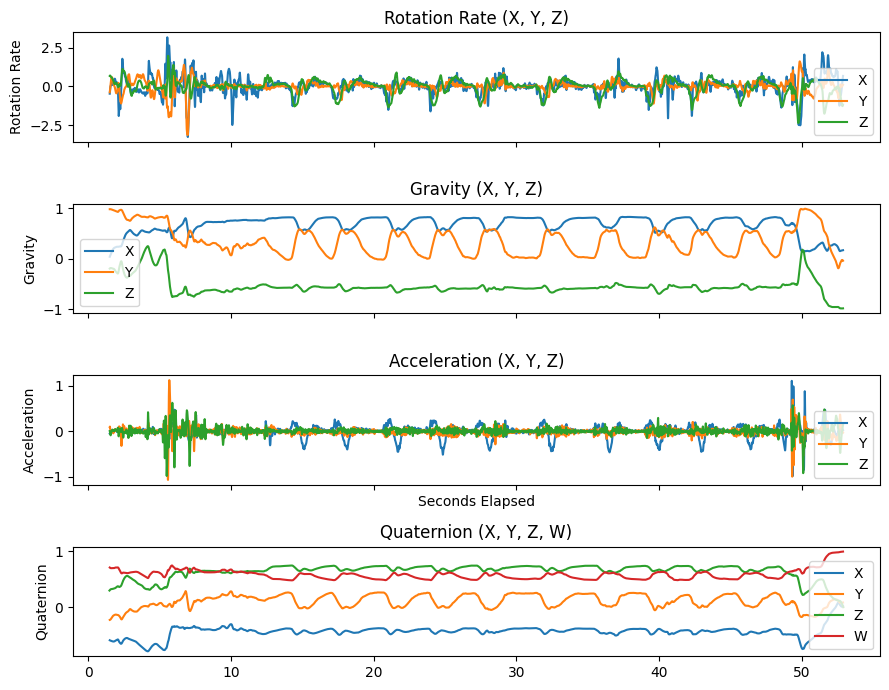

In [6]:
import matplotlib.pyplot as plt
import random

#Picks a random sample
n = random.randint(0, len(data) -1)
df = data[n]

print(f"Sample number: {n+1}, activity: {df['activity'][0]}")

#Smooth the data
df = smooth_columns(df, 5)

# Figure
fig, axes = plt.subplots(4, 1, figsize=(9, 7), sharex=True)

# 1. Rotation Rate
axes[0].plot(df["secondsElapsed"], df["wristMotion_rotationRateX"], label="X")
axes[0].plot(df["secondsElapsed"], df["wristMotion_rotationRateY"], label="Y")
axes[0].plot(df["secondsElapsed"], df["wristMotion_rotationRateZ"], label="Z")
axes[0].set_ylabel("Rotation Rate")
axes[0].set_title("Rotation Rate (X, Y, Z)")
axes[0].legend()

# 2. Gravity
axes[1].plot(df["secondsElapsed"], df["wristMotion_gravityX"], label="X")
axes[1].plot(df["secondsElapsed"], df["wristMotion_gravityY"], label="Y")
axes[1].plot(df["secondsElapsed"], df["wristMotion_gravityZ"], label="Z")
axes[1].set_ylabel("Gravity")
axes[1].set_title("Gravity (X, Y, Z)")
axes[1].legend()

# 3. Acceleration
axes[2].plot(df["secondsElapsed"], df["wristMotion_accelerationX"], label="X")
axes[2].plot(df["secondsElapsed"], df["wristMotion_accelerationY"], label="Y")
axes[2].plot(df["secondsElapsed"], df["wristMotion_accelerationZ"], label="Z")
axes[2].set_ylabel("Acceleration")
axes[2].set_xlabel("Seconds Elapsed")
axes[2].set_title("Acceleration (X, Y, Z)")
axes[2].legend()

# 1. Quaternion
axes[3].plot(df["secondsElapsed"], df["wristMotion_quaternionX"], label="X")
axes[3].plot(df["secondsElapsed"], df["wristMotion_quaternionY"], label="Y")
axes[3].plot(df["secondsElapsed"], df["wristMotion_quaternionZ"], label="Z")
axes[3].plot(df["secondsElapsed"], df["wristMotion_quaternionW"], label="W")

axes[3].set_ylabel("Quaternion")
axes[3].set_title("Quaternion (X, Y, Z, W)")
axes[3].legend()


plt.tight_layout()
plt.show()

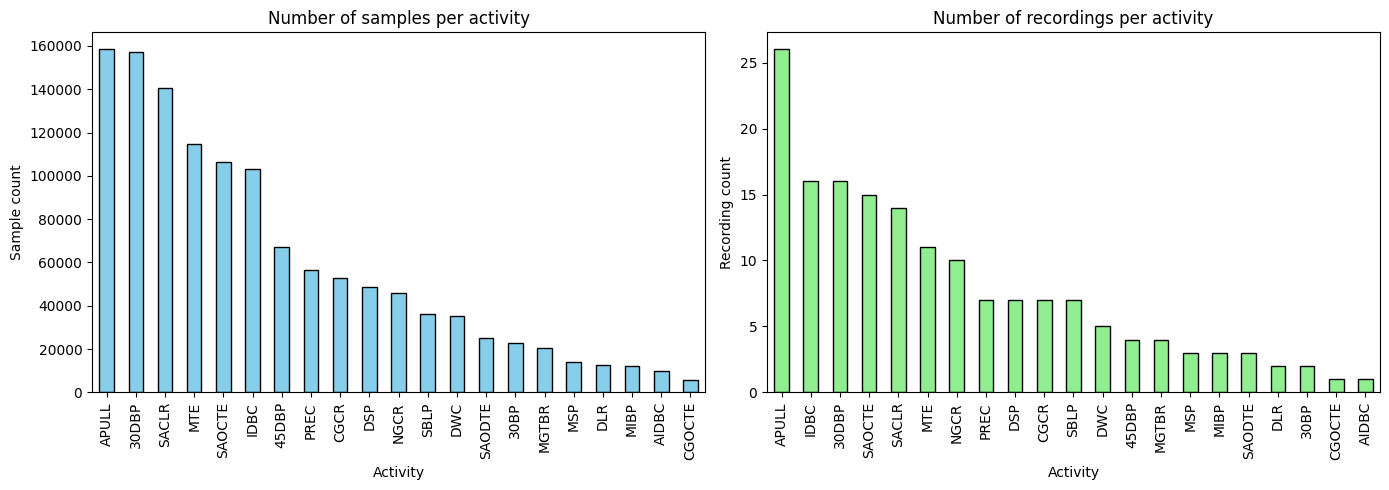

In [7]:
def plots():
    # 1. Combine all dataframes into one
    all_data = pd.concat(data, ignore_index=True)
    
    # Count number of samples (rows) per activity
    sample_counts = all_data["activity"].value_counts()
    
    # 2. Count number of recordings (DataFrames) per activity
    recording_counts = pd.Series([df["activity"].iloc[0] for df in data]).value_counts()
    
    # Plot both
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    # Left: sample counts
    sample_counts.plot(kind="bar", ax=axes[0], color="skyblue", edgecolor="black")
    axes[0].set_title("Number of samples per activity")
    axes[0].set_xlabel("Activity")
    axes[0].set_ylabel("Sample count")
    axes[0].tick_params(axis="x", rotation=90)
    
    # Right: recording counts
    recording_counts.plot(kind="bar", ax=axes[1], color="lightgreen", edgecolor="black")
    axes[1].set_title("Number of recordings per activity")
    axes[1].set_xlabel("Activity")
    axes[1].set_ylabel("Recording count")
    axes[1].tick_params(axis="x", rotation=90)
    
    plt.tight_layout()
    plt.show()
    
plots()

## Activity Distribution: Samples vs Recordings
The dataset can be viewed in two different ways:
1. **Samples per activity**: total number of rows (sensor readings) for each activity.  
   - This reflects the *amount of data* but is biased because recordings have different durations.  
2. **Recordings per activity**: total number of individual sessions (DataFrames) per activity.  
   - This shows the *true balance* in how many times each activity was performed.  

By comparing these two views, we can better understand dataset imbalance and decide how to handle it during training (e.g., weighting).


# 3. Label Encoding & Class Distribution
- Activities are mapped to integer IDs (`activity_to_id`).
- Each DataFrame receives an `activityEncoded` column.
- We combine all data into one DataFrame and plot a histogram to check class distribution.


In [8]:
# 1. Collect all activities from every dataframe
all_activities = pd.concat([df["activity"] for df in data], ignore_index=True)

# 2. Build a global mapping (string -> integer)
categories = all_activities.astype("category").cat.categories
activity_to_id = {cat: idx for idx, cat in enumerate(categories)}

print("Global mapping:", activity_to_id)

# 3. Apply mapping to every dataframe in the list
for i, df in enumerate(data):
    df["activityEncoded"] = df["activity"].map(activity_to_id)
    data[i] = df  # update dataframe in the list

Global mapping: {'30BP': 0, '30DBP': 1, '45DBP': 2, 'AIDBC': 3, 'APULL': 4, 'CGCR': 5, 'CGOCTE': 6, 'DLR': 7, 'DSP': 8, 'DWC': 9, 'IDBC': 10, 'MGTBR': 11, 'MIBP': 12, 'MSP': 13, 'MTE': 14, 'NGCR': 15, 'PREC': 16, 'SACLR': 17, 'SAOCTE': 18, 'SAODTE': 19, 'SBLP': 20}


## Hyperparameters configuration


In [9]:
imu_features = [
    # Gyroscope (angular velocity, rad/s)
    "wristMotion_rotationRateX", "wristMotion_rotationRateY", "wristMotion_rotationRateZ",

    # Gravity vector (orientation of gravity relative to device, g)
    "wristMotion_gravityX", "wristMotion_gravityY", "wristMotion_gravityZ",

    # Linear acceleration (acceleration without gravity, m/s^2)
    "wristMotion_accelerationX", "wristMotion_accelerationY", "wristMotion_accelerationZ",

    # Orientation (unit quaternion components)
    "wristMotion_quaternionW", "wristMotion_quaternionX", "wristMotion_quaternionY", "wristMotion_quaternionZ"
]

In [10]:
for i, df in enumerate(data):  # data must be a list of DataFrames
    if isinstance(df, pd.DataFrame):
        if df[imu_features].isnull().values.any():
            print(f"NaN found in dataframe {i}")
        if np.isinf(df[imu_features].values).any():
            print(f"Inf found in dataframe {i}")
        
        # Replace NaN and Inf values with 0
        df[imu_features] = df[imu_features].fillna(0).replace([np.inf, -np.inf], 0)
        data[i] = df

NaN found in dataframe 42


In [11]:
# Select device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [12]:
def preprocess_sample(window, y, smooth_kernel=5, downsample_factor=2, downsample_mode="avg"):
    """
    Apply (1) moving-average smoothing along time, then (2) downsample.
    Returns (processed_window, processed_label).

    window: np.ndarray of shape (T, F)
    y: int label
    smooth_kernel: odd int window size for moving average (>=1)
    downsample_factor: e.g., 2 to keep half the samples
    downsample_mode:
        - "slice": take every k-th sample (fastest)
        - "avg": average-pool non-overlapping blocks (pads end if needed)
    """
    X = window.astype(np.float32)

    # 1) Smoothing (moving average, 'same' length)
    if smooth_kernel and smooth_kernel > 1:
        k = int(smooth_kernel)
        if k % 2 == 0:
            k += 1  # enforce odd
        kernel = np.ones(k, dtype=np.float32) / k
        # convolve each feature independently
        X = np.vstack([
            np.convolve(X[:, f], kernel, mode="same")
            for f in range(X.shape[1])
        ]).T.astype(np.float32)

    # 2) Downsample
    if downsample_factor and downsample_factor > 1:
        d = int(downsample_factor)
        if downsample_mode == "avg":
            T, F = X.shape
            # pad to make T divisible by d (repeat last row)
            pad_needed = (-T) % d
            if pad_needed:
                X = np.concatenate([X, np.repeat(X[-1:, :], pad_needed, axis=0)], axis=0)
            X = X.reshape(-1, d, F).mean(axis=1)
        else:  # "slice"
            X = X[::d]

    return X, y  # <- two values, as pediste

In [13]:
import torch
from torch.utils.data import Dataset

class IMUDataset(Dataset):
    def __init__(self, dataframes, features, window_size=300, step_size=150,
                 preprocess_fn=None, preprocess_kwargs=None):
        """
        dataframes: list of pandas DataFrames
        features: list of feature column names to use
        window_size: number of timesteps per window (e.g. 300 = 3s at 100Hz)
        step_size: overlap between windows (e.g. 150 = 50% overlap)
        """
        self.samples = []
        self.preprocess_fn = preprocess_fn
        self.preprocess_kwargs = preprocess_kwargs or {}

        for df in dataframes:
            X = df[features].values
            y = int(df["activityEncoded"].iloc[0])  # same label for the whole sequence

            for start in range(0, len(X) - window_size + 1, step_size):
                end = start + window_size
                window = X[start:end]

                if self.preprocess_fn is not None:
                    window, y_out = self.preprocess_fn(window, y, **self.preprocess_kwargs)
                    y_use = y_out
                else:
                    y_use = y

                self.samples.append((window, y_use))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        X = torch.tensor(X, dtype=torch.float32)  # (window_size, num_features)
        y = torch.tensor(y, dtype=torch.long)     # Class
        return X, y


# 4. Dataset Splitting & DataLoaders
We split the dataset into training and test sets.  
- `train_loader`: provides shuffled mini-batches for training.  
- `test_loader`: sequentially iterates over test windows.  
We verify:
- Shape of one sample → `(window_size, num_features)`.  
- Shape of a batch → `(batch_size, window_size, num_features)`.  


## Data parameter Configuration

In [14]:
# Data parameters
window_size = 300                 # timesteps per window (100 ≈ 1 second at 100 Hz)
step_size = 30                   # overlap between windows ( window_size/2 = 50%)

train_split = 0.8

## Make sure all classes are present in the Training Set 

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import warnings

# Build per-session labels (assumes one label per DF; same as your Dataset does)
session_labels = np.array([int(df["activityEncoded"].iloc[0]) for df in data])
n_sessions = len(data)
target_train = int(train_split * n_sessions)

def stratified_session_split(data, labels, train_ratio=0.8, seed=42):
    labels = np.asarray(labels)
    idx_all = np.arange(len(labels))

    # Classes with only 1 session cannot be stratified -> force them into TRAIN
    _, counts = np.unique(labels, return_counts=True)
    cls_counts = dict(zip(*np.unique(labels, return_counts=True)))
    rare_classes = {c for c, k in cls_counts.items() if k < 2}

    forced_train_idx = np.array([i for i in idx_all if labels[i] in rare_classes], dtype=int)
    rest_idx = np.array([i for i in idx_all if labels[i] not in rare_classes], dtype=int)

    if len(rest_idx) == 0:
        warnings.warn("All classes are rare (count<2). Putting all sessions in TRAIN.")
        return forced_train_idx, np.array([], dtype=int)

    # Desired train size for the remaining pool
    remaining_train_needed = max(0, target_train - len(forced_train_idx))
    remaining_total = len(rest_idx)

    if remaining_total == 0 or remaining_train_needed == 0:
        train_idx = forced_train_idx
        test_idx = np.setdiff1d(idx_all, train_idx, assume_unique=False)
        return np.sort(train_idx), np.sort(test_idx)

    # Compute adjusted test_size for the remaining pool
    adjusted_train_ratio = min(1.0, remaining_train_needed / remaining_total)
    adjusted_test_size = 1.0 - adjusted_train_ratio

    # Stratified split on the remaining pool
    sss = StratifiedShuffleSplit(n_splits=1, test_size=adjusted_test_size, random_state=seed)
    rest_labels = labels[rest_idx]
    (rest_train_sel, rest_test_sel), = sss.split(rest_idx, rest_labels)

    train_idx = np.concatenate([forced_train_idx, rest_idx[rest_train_sel]])
    test_idx  = rest_idx[rest_test_sel]

    # Safety: ensure every class present in the whole dataset appears in TRAIN
    present_all = set(np.unique(labels))
    present_train = set(np.unique(labels[train_idx]))
    missing_in_train = present_all - present_train
    if missing_in_train:
        warnings.warn(f"Some classes had too few sessions; moving one session per missing class to TRAIN: {missing_in_train}")
        for cls in list(missing_in_train):
            cand = np.where(labels[test_idx] == cls)[0]
            if len(cand) > 0:
                move = test_idx[cand[0]]
                train_idx = np.append(train_idx, move)
                test_idx = np.delete(test_idx, cand[0])

    return np.sort(train_idx), np.sort(test_idx)



# ---- use the splitter ----
train_idx, test_idx = stratified_session_split(data, session_labels, train_ratio=train_split, seed=42)
train_dfs = [data[i] for i in train_idx]
test_dfs  = [data[i] for i in test_idx]

print(f"Sessions -> train: {len(train_dfs)} | test: {len(test_dfs)}")
# Quick distribution check
test_classes = sorted({int(df['activityEncoded'].iloc[0]) for df in test_dfs})
train_classes = sorted({int(df['activityEncoded'].iloc[0]) for df in train_dfs})
missing_in_test = sorted(set(train_classes) - set(test_classes))
print(f"Train classes ({len(train_classes)}):", train_classes)
print(f"Test classes ({len(test_classes)}):", test_classes, "\nMissing in test:", missing_in_test) 


Sessions -> train: 131 | test: 33
Train classes (21): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Test classes (17): [1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 
Missing in test: [0, 3, 6, 7]


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader


# 2) Fit scaler ONLY on TRAIN using a DataFrame (keeps feature names, no warnings)
scaler = StandardScaler()
train_stack_df = pd.concat([df.loc[:, imu_features] for df in train_dfs], ignore_index=True)
scaler.fit(train_stack_df)   # fitted WITH feature names

# 3) Transform in place (preserve column order and names)
for df in train_dfs:
    df.loc[:, imu_features] = scaler.transform(df.loc[:, imu_features])

for df in test_dfs:
    df.loc[:, imu_features] = scaler.transform(df.loc[:, imu_features])

# (Optional) Keep the scaler for inference/production to apply the same transform:
#   - from joblib import dump, load
#   - dump(scaler, "imu_scaler.joblib")
#   - scaler = load("imu_scaler.joblib")   # later

# 4) Build datasets (one per split) from the pre-scaled DataFrames
#    IMUDataset should NOT re-normalize internally.
train_dataset = IMUDataset(
    dataframes=train_dfs,
    features=imu_features,
    window_size=window_size,
    step_size=step_size,
    preprocess_fn=preprocess_sample,
    preprocess_kwargs=dict(smooth_kernel=5, downsample_factor=2, downsample_mode="avg")
)

test_dataset = IMUDataset(
    dataframes=test_dfs,
    features=imu_features,
    window_size=window_size,
    step_size=step_size,
    preprocess_fn=preprocess_sample,   # mismo preprocesado en test
    preprocess_kwargs=dict(smooth_kernel=5, downsample_factor=2, downsample_mode="avg")
)

# 5) DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1,  shuffle=False)

assert set(map(id, train_dfs)).isdisjoint(set(map(id, test_dfs))), "Leak: same session in both splits"

In [17]:
#Train dataset info
print("Train dataset size:", len(train_dataset))

X, y = train_dataset[0]
print("X shape:", X.shape)   # (window_size, num_features)
print("y:", y)               # label

for X, y in train_loader:
    print("Batch X shape:", X.shape)   # (batch_size, window_size, num_features)
    print("Batch y shape:", y.shape)   # (batch_size,)
    break

#Test dataset info
print("Test dataset size:", len(test_dataset))
X, y = test_dataset[0]
print("X shape:", X.shape)   # (window_size, num_features)
print("y:", y)               # label

for X, y in test_loader:
    print("Batch X shape:", X.shape)   # (batch_size, window_size, num_features)
    print("Batch y shape:", y.shape)   # (batch_size,)
    break
    

Train dataset size: 31173
X shape: torch.Size([150, 13])
y: tensor(16)
Batch X shape: torch.Size([32, 150, 13])
Batch y shape: torch.Size([32])
Test dataset size: 8834
X shape: torch.Size([150, 13])
y: tensor(18)
Batch X shape: torch.Size([1, 150, 13])
Batch y shape: torch.Size([1])


## Exploratory visualization of random IMU windows from the training dataset


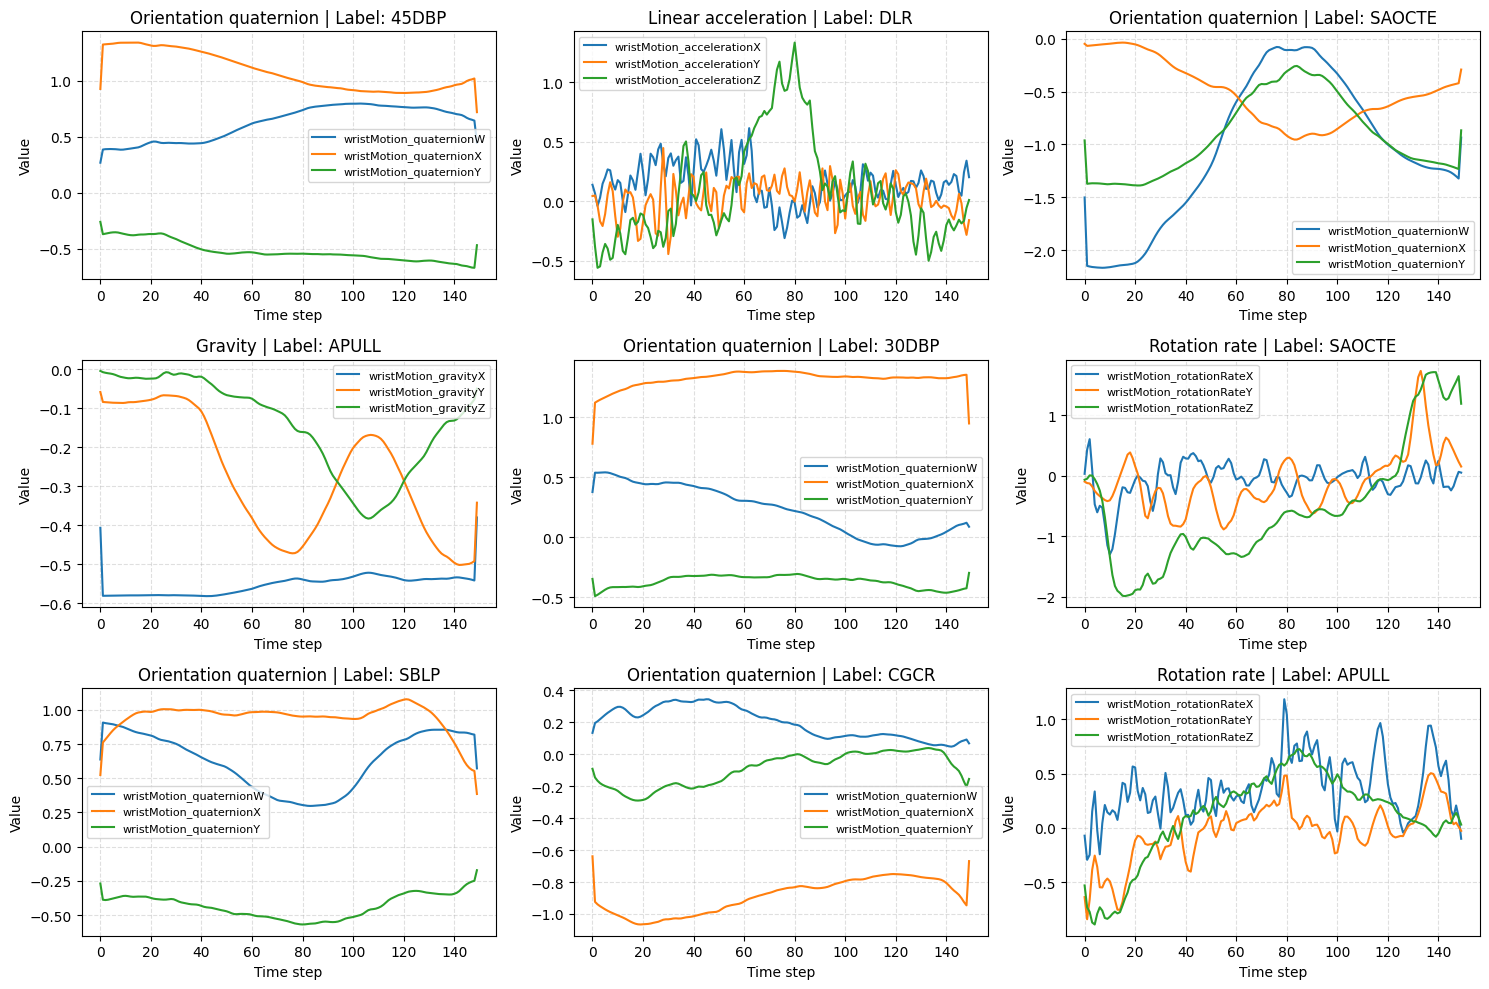

In [18]:
# Define grouped IMU feature sets
imu_groups = {
    "Rotation rate": ["wristMotion_rotationRateX", "wristMotion_rotationRateY", "wristMotion_rotationRateZ"],
    "Gravity": ["wristMotion_gravityX", "wristMotion_gravityY", "wristMotion_gravityZ"],
    "Linear acceleration": ["wristMotion_accelerationX", "wristMotion_accelerationY", "wristMotion_accelerationZ"],
    "Orientation quaternion": ["wristMotion_quaternionW", "wristMotion_quaternionX", "wristMotion_quaternionY", "wristMotion_quaternionZ"]
}

# Pick 9 random samples from the training dataset
num_samples = 9
indices = random.sample(range(len(train_dataset)), num_samples)

# Prepare figure
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

id_to_activity = dict(enumerate(categories))


# Iterate through 9 plots
for i, idx in enumerate(indices):
    X, y = train_dataset[idx]
    X = X.numpy()  # Convert from tensor to numpy
    time_axis = np.arange(X.shape[0])
    y_label = id_to_activity[y.item()]

    # Randomly choose one of the IMU groups (3 main types + quaternion)
    group_name, group_features = random.choice(list(imu_groups.items()))

    # Extract feature indices for this group
    feature_indices = [imu_features.index(f) for f in group_features[:3]]

    # Plot X, Y, Z (or first 3 of the group)
    for j, feat_idx in enumerate(feature_indices):
        axes[i].plot(time_axis, X[:, feat_idx], label=group_features[j])

    axes[i].set_title(f"{group_name} | Label: {y_label}")
    axes[i].set_xlabel("Time step")
    axes[i].set_ylabel("Value")
    axes[i].legend(fontsize=8)
    axes[i].grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


# 5. Handling Imbalanced Data


### ⚖️ Class Weights for Imbalanced Data

Our dataset is imbalanced: some activities have many more samples than others.  
To reduce bias toward frequent classes, we compute **class weights** so that errors on rare classes count more.  
These weights are passed to `CrossEntropyLoss` during training.


    Class ID Activity  Count    Weight
0          6   CGOCTE    183  8.111632
1         13      MSP    261  5.687466
2         12     MIBP    271  5.477596
3          3    AIDBC    324  4.581570
4          7      DLR    400  3.711071
5         11    MGTBR    487  3.048108
6         19   SAODTE    532  2.790279
7          0     30BP    741  2.003277
8          9      DWC    942  1.575827
9         20     SBLP    982  1.511638
10        15     NGCR   1126  1.318320
11        16     PREC   1193  1.244282
12         5     CGCR   1304  1.138365
13         8      DSP   1364  1.088291
14         2    45DBP   1861  0.797651
15        17    SACLR   2638  0.562710
16        10     IDBC   2663  0.557427
17        18   SAOCTE   2834  0.523793
18        14      MTE   3145  0.471996
19         1    30DBP   3756  0.395215
20         4    APULL   4166  0.356320


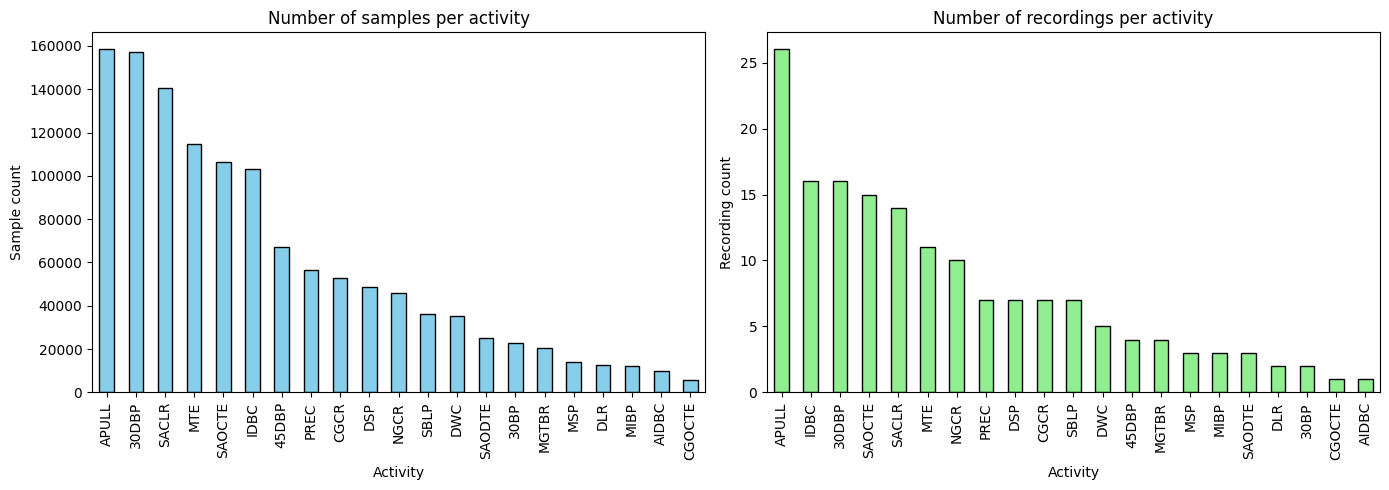

In [19]:
from sklearn.utils.class_weight import compute_class_weight

# 1) Collect training labels only (avoid test leakage)
y_train = [train_dataset[i][1].item() for i in range(len(train_dataset))]

# 2) Define the class ID set aligned with your mapping
#    (use sorted keys in case class IDs are not strictly 0..N-1)
classes = np.array(sorted(id_to_activity.keys()))

# 3) Compute balanced class weights from training labels
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

# 4) Convert to tensor on the correct device and build the loss
class_weights = torch.tensor(class_weights_np, dtype=torch.float32, device=device)


# 5) Count per-class occurrences (support) and build a readable table
class_counts = np.bincount(y_train, minlength=classes.max() + 1)

df_weights = pd.DataFrame({
    "Class ID": classes,
    "Activity": [id_to_activity[i] for i in classes],
    "Count": class_counts[classes],     # index by 'classes' to stay aligned
    "Weight": class_weights_np
}).sort_values("Weight", ascending=False, ignore_index=True)

print(df_weights)

plots()

## Hyperparameter Configuration


In [20]:
# Data parameters
num_features = len(imu_features)  # IMU feature channels (gyro, acc, gravity, quaternion)
num_classes = len(activity_to_id) # 21

# Training parameters
learning_rate = 2e-4
num_epochs = 10

# Model parameters
hidden_dim = 64                   # LSTM hidden dimension
lstm_layers = 2                   # number of stacked LSTM layers

# Optimization / regularization
clip_grad_norm = 1.0              # gradient clipping max norm
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam

# 6. Model Architecture (CNN + LSTM)

The model has two parts:
1. **CNN feature extractor**  
   - Two convolutional layers with batch normalization and max pooling.  
2. **LSTM sequence modeler**  
   - Stacked LSTM layers to capture temporal dependencies.  
3. **Fully connected classifier**  
   - Outputs logits for all activity classes.


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, num_features=13, num_classes=21, hidden_dim=64, lstm_layers=1):
        super(CNN_LSTM, self).__init__()

        # CNN feature extractor
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm1d(128)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )

        # Classifier
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)

        # CNN
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # (batch, channels, seq_len//4)
        x = F.relu(self.bn3(self.conv3(x)))

        # Prepare for LSTM
        x = x.permute(0, 2, 1)  # (batch, seq_len_reduced, channels)

        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq_len_reduced, hidden_dim)
        out = lstm_out[:, -1, :]    # last hidden state

        # Classifier
        out = self.fc(out)
        return out


In [22]:
model = CNN_LSTM(num_features=num_features,
                 num_classes=num_classes,
                 hidden_dim=hidden_dim,
                 lstm_layers=lstm_layers)

criterion = loss_fn

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## CNN_LSTM Summary

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}\n")

for name, param in model.named_parameters():
     print(f"{name}: {param.numel()} parameters")

Total parameters: 179541

conv1.weight: 4160 parameters
conv1.bias: 64 parameters
bn1.weight: 64 parameters
bn1.bias: 64 parameters
conv2.weight: 40960 parameters
conv2.bias: 128 parameters
bn2.weight: 128 parameters
bn2.bias: 128 parameters
conv3.weight: 49152 parameters
conv3.bias: 128 parameters
bn3.weight: 128 parameters
bn3.bias: 128 parameters
lstm.weight_ih_l0: 32768 parameters
lstm.weight_hh_l0: 16384 parameters
lstm.bias_ih_l0: 256 parameters
lstm.bias_hh_l0: 256 parameters
lstm.weight_ih_l1: 16384 parameters
lstm.weight_hh_l1: 16384 parameters
lstm.bias_ih_l1: 256 parameters
lstm.bias_hh_l1: 256 parameters
fc.weight: 1344 parameters
fc.bias: 21 parameters


# 7. Training Loop
For each epoch:
1. Forward pass through the model.  
2. Compute loss and backpropagate.  
3. Apply gradient clipping.  
4. Update parameters with Adam.  
5. Track loss and accuracy per epoch.  


In [24]:
for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0

    for X, y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)   # (batch, num_classes)

        # Loss
        loss = criterion(outputs, y)

        # Skip batch if loss is NaN
        if torch.isnan(loss):
            print("NaN detected! Skipping batch.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    # Accuracy
    epoch_acc = 100 * correct / total if total > 0 else 0
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch}: loss={avg_loss:.4f}, accuracy={epoch_acc:.2f}%")

Epoch 0: loss=1.4907, accuracy=57.83%
Epoch 1: loss=0.7956, accuracy=73.31%
Epoch 2: loss=0.6266, accuracy=77.83%
Epoch 3: loss=0.5300, accuracy=80.13%
Epoch 4: loss=0.4576, accuracy=82.11%
Epoch 5: loss=0.4066, accuracy=83.95%
Epoch 6: loss=0.3748, accuracy=85.16%
Epoch 7: loss=0.3285, accuracy=87.02%
Epoch 8: loss=0.3062, accuracy=87.86%
Epoch 9: loss=0.2644, accuracy=88.95%


# 8. Evaluation and Prediction Analysis

We evaluate the trained model with:
- **Confusion matrix**: shows how predictions align with ground truth.  
- **Classification report**: precision, recall, and F1-score per class. 

To better understand predictions:
- We count predicted classes on the test set.
- A histogram shows which activities are most frequently predicted.
This helps to see if the model is biased toward certain activities.


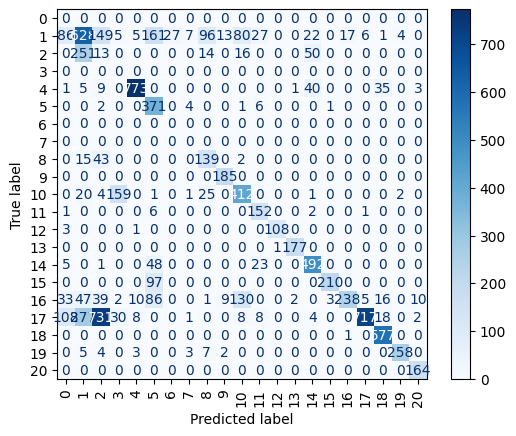

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)

        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.show()

In [26]:
labels_present = sorted(set(y_true) | set(y_pred))
target_names = [id_to_activity[i] if i < len(id_to_activity) else f"class_{i}" for i in labels_present]

print(classification_report(
    y_true, y_pred,
    labels=labels_present,
    target_names=target_names,
    zero_division=0
))


              precision    recall  f1-score   support

        30BP       0.00      0.00      0.00         0
       30DBP       0.50      0.47      0.49      1334
       45DBP       0.01      0.04      0.02       344
       AIDBC       0.00      0.00      0.00         0
       APULL       0.97      0.89      0.93       867
        CGCR       0.48      0.96      0.64       385
      CGOCTE       0.00      0.00      0.00         0
         DLR       0.00      0.00      0.00         0
         DSP       0.49      0.70      0.58       199
         DWC       0.89      1.00      0.94       185
        IDBC       0.63      0.66      0.65       625
       MGTBR       0.70      0.94      0.80       162
        MIBP       0.99      0.96      0.98       112
         MSP       0.98      0.99      0.99       178
         MTE       0.81      0.86      0.83       569
        NGCR       0.98      0.68      0.81       307
        PREC       0.93      0.38      0.54       631
       SACLR       0.98    

In [27]:
import torch
import pandas as pd
from collections import defaultdict, Counter

def summarize_exercise_majority_table(model, data_loader, id_to_activity, device=None, top_confusions=2):
    """
    Build a per-exercise summary table using majority vote across windows.
    Final_acc = 1 if majority class == ground-truth class, else 0.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # 1) Collect predictions per TRUE class (single pass)
    preds_by_true = defaultdict(list)

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            pred = logits.argmax(dim=1)
            for t, p in zip(y.tolist(), pred.cpu().tolist()):
                preds_by_true[t].append(p)

    rows = []
    for true_id, pred_ids in preds_by_true.items():
        true_name = id_to_activity[true_id]
        total = len(pred_ids)
        name_counts = Counter(id_to_activity[p] for p in pred_ids)

        # Majority class and percentage
        majority_name, majority_count = name_counts.most_common(1)[0]
        majority_pct = majority_count / total if total else 0.0

        # Final acc as 1/0 (majority == true)
        final_acc = 1 if majority_name == true_name else 0

        # Top confusions (exclude the true class)
        confusions = [(n, c) for n, c in name_counts.items() if n != true_name]
        confusions_sorted = sorted(confusions, key=lambda x: x[1], reverse=True)[:top_confusions]
        top_confusions_str = ", ".join(f"{n} ({c})" for n, c in confusions_sorted) if confusions_sorted else ""

        rows.append({
            "Exercise": true_name,
            "#Windows": total,
            "Majority class": f"{majority_name} ({majority_pct:.2%})",
            "Final_acc": final_acc,
            "Top confusions": top_confusions_str,
        })

    df = pd.DataFrame(rows).sort_values(["Final_acc", "#Windows"], ascending=[False, False]).reset_index(drop=True)
    return df

In [28]:
import math
import torch
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def plot_grid_topk_predictions_per_true_class(
    model,
    data_loader,
    id_to_activity,
    device=None,
    cols=4,
    topk=5,
):
    """
    For each *ground-truth* class present in the loader, plot a bar chart with
    the Top-K predicted classes (+ 'Other' for the remainder) in a grid of subplots.

    Args:
        model: trained PyTorch model
        data_loader: DataLoader yielding (X, y)
        id_to_activity: dict {int: str}
        device: torch.device (inferred from model if None)
        cols: number of subplot columns (default 4)
        topk: number of top predicted classes to display before 'Other' (default 5)
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # ---- 1) Single pass: accumulate predictions per TRUE class ----
    # For each true class id: list of predicted ids (to compute topk) and counters for accuracy.
    preds_by_true = defaultdict(list)
    correct_by_true = Counter()
    count_by_true = Counter()

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            pred = outputs.argmax(dim=1)

            # Accumulate per true class
            for t, p in zip(y.tolist(), pred.cpu().tolist()):
                preds_by_true[t].append(p)
                count_by_true[t] += 1
                if t == p:
                    correct_by_true[t] += 1

    # Classes that truly exist in the loader
    present_classes = sorted(preds_by_true.keys())
    num_present = len(present_classes)
    print(f"Present classes in loader: {num_present} -> {', '.join(id_to_activity[c] for c in present_classes)}")

    if num_present == 0:
        print("No samples found in the provided DataLoader.")
        return

    # ---- 2) Figure and axes grid ----
    rows = math.ceil(num_present / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 3.2*rows))
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    # ---- 3) Build each subplot (Top-K + Other) ----
    for idx, true_cls in enumerate(present_classes):
        r, c = divmod(idx, cols)
        ax = axes[r][c]

        # Count predictions for this true class
        pred_ids = preds_by_true[true_cls]
        total_n = count_by_true[true_cls]
        acc = correct_by_true[true_cls] / total_n if total_n > 0 else 0.0

        pred_names = pd.Series(pred_ids).map(id_to_activity)
        counts = pred_names.value_counts()

        # Top-K + Other
        top_counts = counts.head(topk)
        other = counts.iloc[topk:].sum() if len(counts) > topk else 0
        bars = list(top_counts.index)
        values = list(top_counts.values)
        bars.append("Other")
        values.append(other)

        # Plot
        ax.bar(bars, values, edgecolor="black")
        ax.set_title(f"{id_to_activity[true_cls]} (n={total_n}, acc={acc:.2%})", fontsize=10)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", labelrotation=45)
    
    # Hide any unused subplots
    total_axes = rows * cols
    for k in range(num_present, total_axes):
        r, c = divmod(k, cols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

# FINAL CONCLUSIONS

- Per-window predictions can be noisy due to sensor noise and transition frames.
- Aggregating many windows from the **same exercise** (majority vote or summed probabilities) makes the **dominant class** match the true label in most cases, sharply boosting per-exercise accuracy.
- Use **exercise-level aggregation** for decisions/feedback; keep window outputs for diagnostics.
- In the attached figure, the **tallest bar** coincides with the ground-truth class for most exercises.


   Exercise  #Windows   Majority class  Final_acc            Top confusions
0     30DBP      1334   30DBP (47.08%)          1   CGCR (161), 45DBP (149)
1     APULL       867   APULL (89.16%)          1     MTE (40), SAOCTE (35)
2      PREC       631    PREC (37.72%)          1     IDBC (130), CGCR (86)
3      IDBC       625    IDBC (65.92%)          1     AIDBC (159), DSP (25)
4    SAOCTE       578  SAOCTE (99.83%)          1                  PREC (1)
5       MTE       569     MTE (86.47%)          1     CGCR (48), MGTBR (23)
6      CGCR       385    CGCR (96.36%)          1        MGTBR (6), DLR (4)
7      NGCR       307    NGCR (68.40%)          1                 CGCR (97)
8    SAODTE       282  SAODTE (91.49%)          1        DSP (7), 30DBP (5)
9       DSP       199     DSP (69.85%)          1    45DBP (43), 30DBP (15)
10      DWC       185    DWC (100.00%)          1                          
11      MSP       178     MSP (99.44%)          1                  MIBP (1)
12     SBLP 

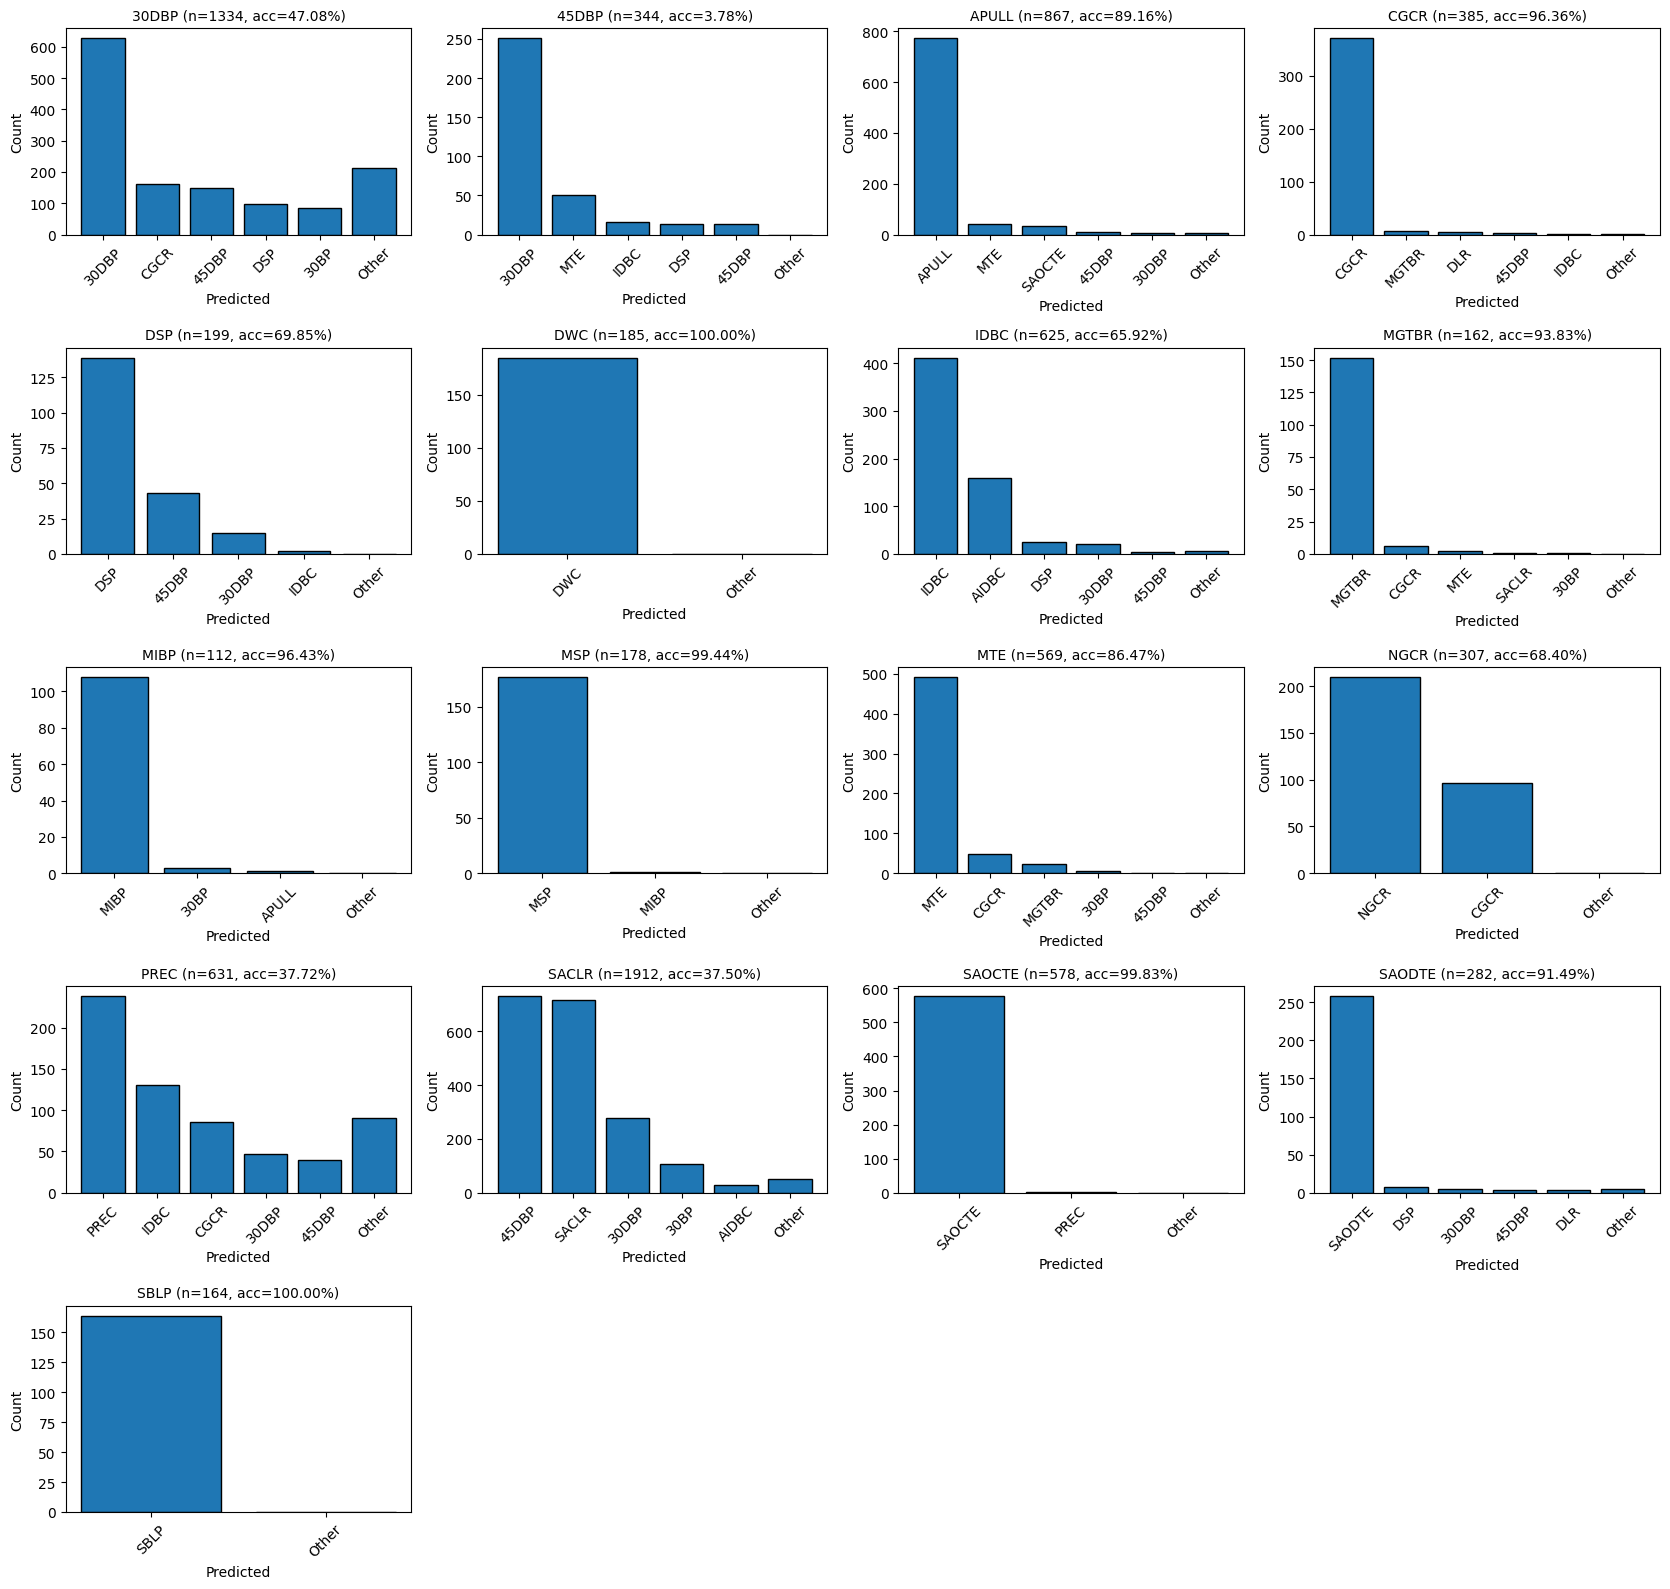

In [29]:
# --- Usage ---
id_to_activity = dict(enumerate(categories))
table = summarize_exercise_majority_table(model, test_loader, id_to_activity)
print(table)
# table.to_csv("exercise_majority_summary.csv", index=False)

overall_majority_acc = table["Final_acc"].mean()
print(f"Majority-vote exercise accuracy: {overall_majority_acc:.2%}")

plot_grid_topk_predictions_per_true_class(
    model=model,
    data_loader=test_loader,
    id_to_activity=id_to_activity,
    cols=4,
    topk=5
)